In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

$$z^{k+1}_j = y^k_i w^{k+1}_{ij} + b^{k+1}\,,$$

where $k$ is the layer index and $j$ is the index of neurons in layer $k$.

The $z$ values are further passed to step function to obtain output of $k+1_{th}$ layer.

$$y^{k+1}_j = \frac{1}{1-e^{-z^{k+1}_j}}$$

The output of neurons for a layer is along the rows of $y$. Different rows contain different input samples for the network.

Another trick to remember is how python adds vector to a matrix.

Suppose $b$ is a vector of dimension $N_{in}$, and $A$ is a matrix of dimension $N_{samples}\times N_{in}$.

Then, the expression $$M = A + B$$ will produce $$M_{ij} = A_{ij} + b_j.$$

Broadly, the network consists of four parts: the observation input O, the latent representation R, the question Q, and the answer A. All of the data are real.

The observation consists of $N_o$ neurons. The signal is feed to the encoder E that outputs a representation of the observation i.e. the latent representation. R consists of $N_r$ neurons. The question is made up of $N_q$ neurons. The output from R and Q are feed to decoder that provides the the answer from $N_a$ neurons.

The number of layers in the encoder and decoder are $L_e$ and $L_d$. ${E_1,\ldots, E_{L_e}}$ are the number of neurons in the layers of the encoder. ${D_1,\ldots, D_{L_d}}$ are the number of neurons in the layers of the decoder.

In [ ]:
from time import time

In [ ]:
rows = 10
cols = 7
dim = rows*cols
a = np.arange(dim).reshape(rows, cols)
print(a)

[[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]
 [28 29 30 31 32 33 34]
 [35 36 37 38 39 40 41]
 [42 43 44 45 46 47 48]
 [49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62]
 [63 64 65 66 67 68 69]]


In [ ]:
print(a[[1,2,6], :])

[[ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [42 43 44 45 46 47 48]]


In [ ]:
a.mean(axis=1)

array([0.66666667, 4.        ])

In [ ]:
print(a - a.mean(axis=1).reshape(-1, 1))

[[ 0.33333333 -2.66666667  2.33333333]
 [-2.          0.          2.        ]]


In [ ]:
a.var(axis=1)

array([4.22222222, 2.66666667])

In [13]:
class NeuralNet:
  def __init__(self):
    pass
  def getLayerSize(self, layer_num):
    return self.num_neurons[layer_num-1]
  def createLayers(self, num_neurons=np.array([10, 100, 10])):
    self.num_layers = len(num_neurons)
    """if num_layers != len(num_neurons) raise exception"""
    self.num_neurons = num_neurons
    self.layer_weights = [None]*(self.num_layers-1)
    self.layer_biases = [None]*(self.num_layers-1)
    for i in range(self.num_layers-1):
      self.layer_weights[i] = np.random.uniform(low=-1, high=1, size=[num_neurons[i+1], num_neurons[i]])
      self.layer_biases[i] = np.random.uniform(low=-1, high=1, size=[1,num_neurons[i+1]])

  def getLayerOutput(self, input, layer):
    if layer>1:
      """if len(inout) != num_neurons[0] raise exception"""
      Z_layer = np.dot(input, self.layer_weights[0].T) + self.layer_biases[0]
      #layer_output = 1/(1+np.exp(-2*Z_layer))
      #ReLu activation function
      layer_output = np.maximum(0, Z_layer)

      if layer>2:
        for i in range(1, layer-1):
          Z_layer = np.dot(layer_output, self.layer_weights[i].T) + self.layer_biases[i]
          #layer_output = 1/(1+np.exp(-2*Z_layer))
          #ReLu activation function
          layer_output = np.maximum(0, Z_layer)
      return layer_output
    else:
      return input


  def applyNet(self, input):
    """if len(inout) != num_neurons[0] raise exception"""
    Z_layer = np.dot(input, self.layer_weights[0].T) + self.layer_biases[0]
    #layer_output = 1/(1+np.exp(-2*Z_layer))
    #ReLu activation function
    layer_output = np.maximum(0, Z_layer)

    for i in range(1, self.num_layers-1):
      Z_layer = np.dot(layer_output, self.layer_weights[i].T) + self.layer_biases[i]
      #layer_output = 1/(1+np.exp(-2*Z_layer))
      #ReLu activation function
      layer_output = np.maximum(0, Z_layer)
    return layer_output

  def applyNetWithfeedAtLayer(self, input, feed, layer_num):
    """if len(inout) != num_neurons[0] raise exception"""
    if layer_num == 1:
      """if len(input) != len(feed) raise exception"""
      input = input + feed
    Z_layer = np.dot(input, self.layer_weights[0].T) + self.layer_biases[0]
    #layer_output = 1/(1+np.exp(-2*Z_layer))
    #ReLu activation function
    layer_output = np.maximum(0, Z_layer)

    for i in range(1, self.num_layers):
      if i == layer_num-1:
        layer_output = layer_output + feed
      Z_layer = np.dot(layer_output, self.layer_weights[i].T) + self.layer_biases[i]
      #layer_output = 1/(1+np.exp(-2*Z))
      #ReLu activation function
      layer_output = np.maximum(0, Z_layer)
    return layer_output

  def normalize(self, Y):
    normalized_Y = Y - Y.mean(axis=1).reshape(-1,1)
    normalized_Y /= np.sqrt(Y.var(axis=1).reshape(-1,1))
    return normalized_Y

  def NetworkOptimization(self, Y_in, Y0, training_count=50, update_method='gradient'):
    samples = len(Y_in)
    MSE = np.zeros(training_count).reshape(-1)

    for batch in range(training_count):
      #create a list of y values to store the output from each neurons in the network
      y_layers = [np.zeros([samples, self.num_neurons[i]]) for i in range(self.num_layers)]
      dSigmadZ_layers = []

      """forward pass to calculate the output and dSigmadZ for every neurons"""
      y_layers[0] = Y_in.copy()
      layer_output = Y_in.copy()

      for i in range(1, self.num_layers):
        Z_layer = np.dot(layer_output, self.layer_weights[i-1].T) + self.layer_biases[i-1]
        Z_layer.reshape(samples, self.num_neurons[i])

        dSigmadZ_layers.append(Z_layer)
        #ReLu activation function
        layer_output = np.maximum(0, Z_layer)
        y_layers[i] = layer_output.copy()
      """forward pass ends"""

      #calculate derivative of sigma(z) using the values stored in dSigmadZ
      for x in dSigmadZ_layers:
        x[x<=0] = self.act_left_slope
        x[x>0] = self.act_right_slope

      dCostdW_layers = [None]*(self.num_layers-1)
      dCostdB_layers = [None]*(self.num_layers-1)

      weights_to_update = [None]*(self.num_layers-1)
      biases_to_update = [None]*(self.num_layers-1)

      #iterate through layers starting from the second outermost layer
      for layer_iter in range(-2, -self.num_layers-1, -1):
        #select about half of the weights and biases in each layer
        #randomly selects indices within the size of row dimension of the layer_weights and stores as list of lists

        weights_rows = [[x] for x in random.sample(range(self.num_neurons[layer_iter+1]), 1 + int(self.num_neurons[layer_iter+1]/2))]
        #randomly create a list of indices about half the column size of layer_weights
        weights_cols = random.sample(range(self.num_neurons[layer_iter]), 1+int(self.num_neurons[layer_iter]/2))
        #randomly create a list of indices about half in number than the number of neurons in layer i+1
        biases_cols = random.sample(range(self.num_neurons[layer_iter+1]), 1+int(self.num_neurons[layer_iter+1]/2))

        #selects about half of the weights in layer i and stores as a 2D array
        weights_to_update[layer_iter+1] = [weights_rows, weights_cols]
        biases_to_update[layer_iter+1] = biases_cols

        if layer_iter == -2:
           #initialize the derivative of cost function from the output layer
           dY = y_layers[layer_iter+1] - Y0

           Delta = dY*dSigmadZ_layers[layer_iter+1]
           dCostdB = Delta.mean(axis=0).reshape(1,-1)
           dCostdW = np.dot(Delta.T, y_layers[layer_iter])/samples

           dCostdW_layers[layer_iter+1] = dCostdW[weights_rows, weights_cols]
           dCostdB_layers[layer_iter+1] = dCostdB[0, biases_cols]
        else:
           Delta = np.dot(Delta, self.layer_weights[layer_iter+2])*dSigmadZ_layers[layer_iter+1]
           dCostdB = Delta.mean(axis=0).reshape(1,-1)
           dCostdW = np.dot(Delta.T, y_layers[layer_iter])/samples

           dCostdW_layers[layer_iter+1] = dCostdW[weights_rows, weights_cols]
           dCostdB_layers[layer_iter+1] = dCostdB[0, biases_cols].reshape(1,-1)

      paramUpdate = getattr(self, (update_method+'Update'))
      paramUpdate(weights_to_update, biases_to_update, dCostdW_layers, dCostdB_layers)

      MSE[batch] = ((self.applyNet(Y_in)-Y0)**2).mean()
    return MSE

  def training(self, Y_in, Y0, batchsize=10, training_per_batch=50, update_method='gradient'):
    self.learning_rate = 1.0e-3
    self.threshold = 0.01
    self.act_left_slope = 0.1
    self.act_right_slope = 0.3
    self.batchsize = batchsize

    MSE = [None]*batchsize
    batch_indices = self.getBatchIndices(len(Y_in), batchsize)

    for batch in range(batchsize):
      MSE[batch] = self.NetworkOptimization(Y_in[batch_indices[batch], :], Y0[batch_indices[batch], :], training_per_batch, update_method)
    return MSE

  def gradientUpdate(self, weights_to_update, biases_to_update, dCostdW_layers, dCostdB_layers):
    for i in range(0, self.num_layers-1):
      self.layer_weights[i][weights_to_update[i][0], weights_to_update[i][1]] -= self.learning_rate*dCostdW_layers[i]
      self.layer_biases[i][0, biases_to_update[i]] -= self.learning_rate*dCostdB_layers[i].reshape(-1)

  def velocityGradientUpdate(self, weights_to_update, biases_to_update, dCostdW_layers, dCostdB_layers):
    rho = 0.9
    weight_velocity = [0]*self.num_layers
    bias_velocity = [0]*self.num_layers

    for i in range(0, self.num_layers-1):
      weight_velocity[i] = rho*weight_velocity[i] + dCostdW_layers[i]
      bias_velocity[i] = rho*bias_velocity[i] + dCostdB_layers[i]
      self.layer_weights[i][weights_to_update[i][0], weights_to_update[i][1]] -= self.learning_rate*weight_velocity[i]
      self.layer_biases[i][0, biases_to_update[i]] -= self.learning_rate*bias_velocity[i].reshape(-1)

  def getBatchIndices(self, total_count, batchsize):
    rng = np.random.default_rng()
    indices = rng.permutation(total_count)
    indices = np.array_split(indices, batchsize)
    return indices

Let's test the network by creating an autoencoder.

In [2]:
#takes a list of flattened image data and plots the image list in rows
def plotDigits(x_img, cols=5):
  #pick five random indices from the sample range of the image data
  random_sample_indices = [np.random.randint(low=0, high=x_img[0].shape[0]) for i in range(5)]
  #select the five images
  random_sample_images = x_img[0][random_sample_indices, :]

  #number of rows to be plotted
  rows = len(x_img)
  #create subplot axes
  fig, ax = plt.subplots(nrows=rows, ncols=cols, squeeze=False)

  for row in range(rows):
    for i, index in enumerate(random_sample_indices):
      #the image pixels are in flattened array
      #reshape the pixel array to 28*28 dimension
      ax[row, i].imshow(x_img[row][index].reshape(28,28), cmap='gray')
      ax[row, i].grid=False
      ax[row, i].set_xticks([])
      ax[row, i].set_yticks([])

  return ax, fig

## Getting Dataset

In [1]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


[]

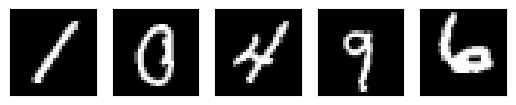

In [6]:
#plot five random digits
ax, fig = plotDigits([x_train], cols=5)
plt.plot()

layer1 = keras.layers.Dense(28*28, activation='relu', name='hidden_layer1')
layer2 = keras.layers.Dense(1, activation='relu', name='hidden_layer2')
output = keras.layers.Dense(28*28, activation='relu', name='output_layer')

## Preprocessing input

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)


In [8]:
#flatten the pixel array of the images
def reshapeImage(images, normalize=False):
  images_reshaped = images.reshape((images.shape[0], images.shape[1]*images.shape[2]))

  if normalize:
    #reduce the range of values to [0,1]
    images_reshaped = images_reshaped.astype('float32')/255

  return images_reshaped

In [9]:
#flatten and normalize the pixel values of the digits to [0,1]
x_train_reshaped = reshapeImage(x_train, normalize=True)
x_test_reshaped = reshapeImage(x_test, normalize=True)

In [10]:
print(x_train_reshaped.shape)
print(x_test_reshaped.shape)

(60000, 784)
(10000, 784)


## Training the model

In [11]:
input_image_size = 28*28
#the size of the latent representation
latent_rep_size = 32

In [26]:
autoencoder = NeuralNet()
autoencoder.createLayers(num_neurons=np.array([input_image_size, latent_rep_size, input_image_size]))

In [ ]:
epoch = 5
for i in range(epoch):
  print("epoch " + str(i+1))
  MSE = autoencoder.training(x_train_reshaped, x_train_reshaped, batchsize=100, training_per_batch=50, update_method='velocityGradient')

In [ ]:
x_predicted_reshaped = autoencoder.applyNet(x_test_reshaped)

In [ ]:
x_predicted_reshaped = np.clip(x_predicted_reshaped, a_min=0, a_max=1)

[]

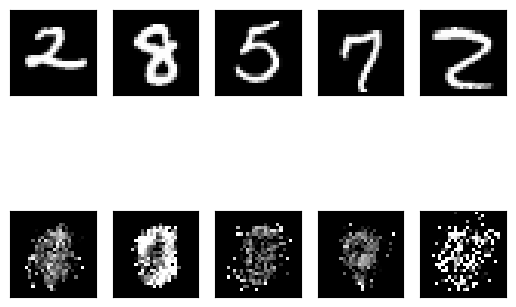

In [34]:
ax, fig = plotDigits([x_test_reshaped, x_predicted_reshaped], cols=5)
plt.plot()

[]

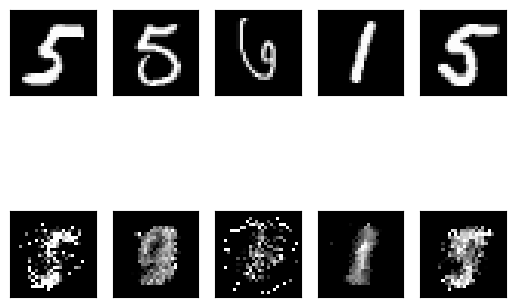

In [38]:
ax, fig = plotDigits([x_test_reshaped, x_predicted_reshaped], cols=5)
plt.plot()

In [ ]:
layer_output = [None]*5
for layer in range(0, 5):
  layer_output[layer] = autoencoder.getLayerOutput(xt, layer+1)

In [ ]:
autoencoder.learning_rate = 1.0e-3
#autoencoder.act_right_slope = 0.15

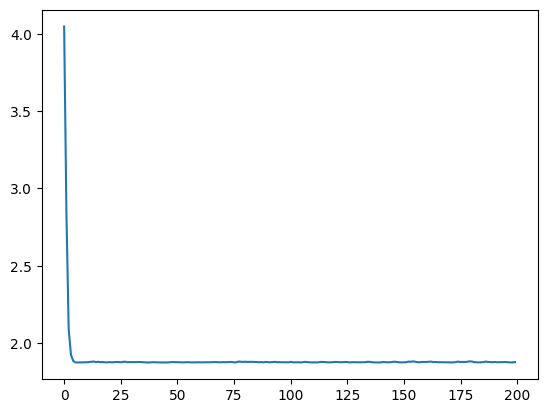

In [ ]:
plt.plot(sum_squared_error)
plt.show()

In [ ]:
layer_output = [None]*4
for layer in range(0, 4):
  layer_output[layer] = autoencoder.getLayerOutput(xt, layer+1)

In [ ]:
for x in layer_output:
  print(x.mean())

0.4171384820652942
3.191003511167692
11.57663906749102
0.9999999976321668


Equation of motion: $$m \ddot x = -kx-b\dot x.$$

Solution: $$x(t) = A\exp\left(-\frac{b}{2m}t\right)\cos(\omega t + \delta).$$

The trajectory of the pendulum is obtained at equally spaced $t_i, i=1,\ldots 50$, where $t\in [0, 5]s.$

For the training purpose, the following parameters are kept fixed:

$$m = 1kg,\; A = 1m,\; \delta = 0,$$

and the following parameters are varied to obtain different samples

$$b\in [0.5,1] kg/s,\; k\in [5,10]kg/s^2.$$

In [ ]:
"""generate data for simple damped pendulum"""
t0 = 0
t1 = 5
N = 50
samples = 500

#parameters
bk = np.zeros((samples, 2))
#damping constant
bk[0, 0] = 0.5
#spring constant
bk[0, 1] = 5
omega = np.sqrt(bk[0, 1] - bk[0, 0]**2/4)
b_range = 0.5
k_range = 5
db = b_range/samples
dk = k_range/samples

dt = (t1-t0)/N
t = (np.linspace(t0, t1, N)).reshape(1, N)
xt = np.zeros((samples, N))
for i in range(samples):
  xt[i,:] = (np.exp(-bk[i, 0]*t/2)*np.cos(omega*t))#.reshape(1, N)
  if i<samples-1:
    bk[i+1, 0] = bk[i, 0] + db
    bk[i+1, 1] = bk[i, 1] + dk
    omega = np.sqrt(bk[i+1, 1] -bk[i+1, 0]**2/4)

In [ ]:
autoencoder.applyNet(xt)

array([[0., 0.]])

In [ ]:
alpha = 0.0001
threshold = 0.01
batch_size = 10

In [ ]:
class DampedPendulum:
  def __init__():
    pass
  def createEncoder(self, num_layers=4, num_neurons=np.array([50, 500, 100, 3])):
    self.Encoder = NeuralNet()
    self.Encoder.createLayers(num_layers, num_neurons)
  def createDecoder(self, num_layers=4, num_neurons=np.array([3, 100, 100, 1])):
    self.Decoder = NeuralNet()
    self.Decoder.createLayers(num_layers, num_neurons)
  def createQuestion(self, num_layers=2, num_neurons=np.array([1, 100])):
    self.Question = NeuralNet()
    self.Question.createLayers(num_layers, num_neurons)
  def applyNet(self, input, question, ques_at_layer):
    latent_representation = self.Encoder.applyNet(input)
    question = self.Question.applyNet(question)
    answer = self.Decoder.applyNetWithfeedAtLayer(latent_representation, question, ques_at_layer)
    return answer

In [ ]:
class Encoder:
  def __init__():
    pass
  def setInputSize(self, size):
    self.N_o = size
  def createLayers(self, num_layers=3, num_neurons=np.array([100, 100, 100])):
    self.num_layers = num_layers
    self.num_neurons = num_neurons
    self.layer_weights = [None]*num_layers
    self.layer_biases = [None]*num_layers
    for i in range(num_layers-1):
      self.layer_weights[i] = np.random.uniform(low=-1, high=1, size=[num_neurons[i+1], num_neurons[i]])
      self.layer_biases[i] = np.random.uniform(low=-1, high=1, size=num_neurons[i+1])
  def encode(self, input):
    Z1 = np.dot(layer_weights[0], input) + layer_biases[0]
    A1 = 1/(1+np.exp(-2*Z1))

    for i in range(1, num_layers):
      Z1 = np.dot(layer_weights[i], A1) + layer_biases[i]
      A1 = 1/(1+np.exp(-2*Z1))
    return A1

In [ ]:
for x in range(10):
  print(x, end="")

0123456789

In [ ]:
class Decoder:
  def __init__():
    pass
  def setInputSize(self, size):
    self.N_d = size
  def createLayers(self, num_layers=3, num_neurons=np.array([100, 100, 1])):
    self.num_layers = num_layers
    self.num_neurons = num_neurons
    self.layer_weights = [None]*num_layers
    self.layer_biases = [None]*num_layers
    for i in range(num_layers-1):
      self.layer_weights[i] = np.random.uniform(low=-1, high=1, size=[num_neurons[i+1], num_neurons[i]])
      self.layer_biases[i] = np.random.uniform(low=-1, high=1, size=num_neurons[i+1])
  def decode(self, input):
    Z1 = np.dot(layer_weights[0], input) + layer_biases[0]
    A1 = 1/(1+np.exp(-2*Z1))

    for i in range(1, num_layers):
      Z1 = np.dot(layer_weights[i], A1) + layer_biases[i]
      A1 = 1/(1+np.exp(-2*Z1))
    return A1

In [ ]:
weights_o = np.random.uniform(low=-1, high=1, size=[N_o, N_e1])
biases_o = np.random.uniform(low=-1, high=1, size=N_e1

In [ ]:
weights_initial = np.random.uniform(low=-1, high=1, size=[N_in, N_h])
biases_initial = np.random.uniform(low=-1, high=1, size=N_h)

weights_layer = np.random.uniform(low=-3, high=3, size=[N_layers, N_h, N_h])
biases_layer = np.random.uniform(low=-1, high=1, size=[N_layers, N_h])

weights_final = np.random.uniform(low=-1, high=1, size=[N_h, N_out])
biases_final = np.random.uniform(low=-1, high=1, size=N_out)

In [ ]:
def applyLayer(y_in, w, b):
    z = np.dot(y_in, w) + b
    return 1/(1+np.exp(-2*z))
    #return (z*(z>0))

In [ ]:
def applyNet(y_in):
    y = applyLayer(y_in, weights_initial, biases_initial)

    for i in range(N_layers):
        y = applyLayer(y, weights_layer[i,:,:], biases_layer[i,:])

    y_out = applyLayer(y, weights_final, biases_final)
    return y_out

In [ ]:
#size of the grid
M = 500
#generate a mesh grid for x, y values in image
x_axis = np.linspace(-0.5,0.5, M)
y_axis = np.linspace(-0.5, 0.5, M)

#create a grid of xy values to input to the network. Different xy values provide different samples of input.
v0, v1 = np.meshgrid(x_axis, y_axis)
#Total number of samples
batchsize = M**2
#create a matrix for input whose rows contain all M^2 samples
y_in = np.zeros([batchsize, 2])
y_in[:,0] = v0.flatten()
y_in[:,1] = v1.flatten()

In [ ]:
y_out = applyNet(y_in)

In [ ]:
y_2D = np.reshape(y_out[:,0], [M,M])

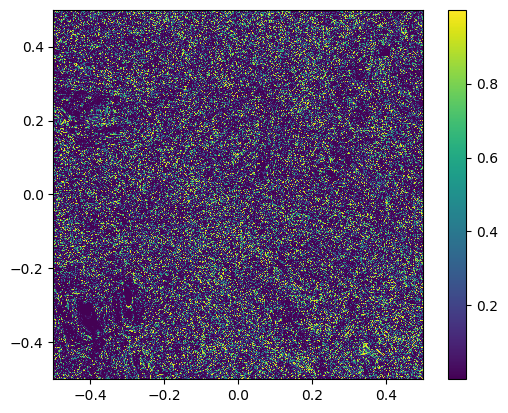

In [ ]:
plt.imshow(y_2D, origin='lower', extent=[-0.5,0.5,-0.5,0.5], interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
v2, v3 = np.meshgrid(np.linspace(0,10,5), np.linspace(0,12,4), indexing="ij")
print(v3)
print(v3.flatten())

[[ 0.  4.  8. 12.]
 [ 0.  4.  8. 12.]
 [ 0.  4.  8. 12.]
 [ 0.  4.  8. 12.]
 [ 0.  4.  8. 12.]]
[ 0.  4.  8. 12.  0.  4.  8. 12.  0.  4.  8. 12.  0.  4.  8. 12.  0.  4.
  8. 12.]


Approximating a one dimensional scalar function.

1. There is one input neuron.
2. There is one hidden layer. The number of neurons in the hidden layer determine the accuracy of the approximation.
3. There is one output neuron. An appropriate linear combination of outputs from hidden layer neurons gives the approximation to function.

In [ ]:
N_i = 1
N_s = 200
N_h = 100
N_o = 1

#array to discritize the domain of the function
Y = np.linspace(0, 1, N_s)
#input for the function. Values at which function is to be evaluated
y_in = np.linspace(0, 1, 100)
y_in = y_in.reshape(100, 1)
y_out = np.array((N_s, N_o))

In [ ]:
w1 = np.random.uniform(low=-5, high=5, size = (N_i, N_h))
w2 = np.random.uniform(low=-1, high=1, size = (N_h,N_o))
#w2= np.ones(N_h).reshape(N_h,N_o)

#b1 = np.random.uniform(low=-1, high=1, size = (N_i, N_h))
#b2 = np.random.uniform(low=-1, high=1, size = (N_o, N_o))


In [ ]:
#z = np.dot(y_in, w1)
z = 5*(y_in-Y)
y_hidden = 1/(1+np.exp(-z))

y_out = np.dot(y_hidden, w2)
#y_out = 1/(1+np.exp(-z))

<class 'ValueError'>: shapes (100,200) and (100,1) not aligned: 200 (dim 1) != 100 (dim 0)

In [ ]:
x = y_in.flatten()
y = y_out.flatten()

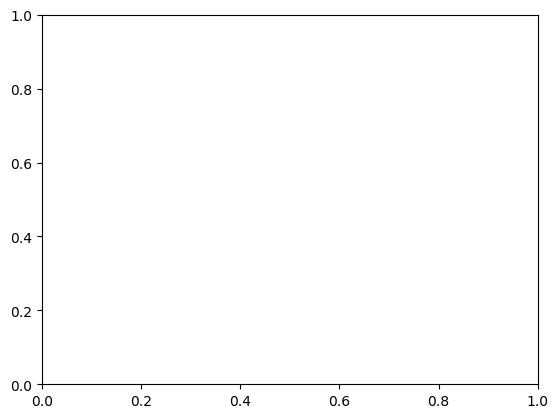

<class 'ValueError'>: x and y must have same first dimension, but have shapes (100,) and (2,)

In [ ]:
plt.plot(x, y)
plt.show()